In [6]:
import pandas as pd
import rdkit
from rdkit import DataStructs, Chem
from rdkit.Chem import MACCSkeys, Draw
import torch
import numpy as np

## Vocab Generation

In [15]:
from fast_jtnn.mol_tree import main_mol_tree
# main_mol_tree('./data/train.txt', './data/vocab.txt')

## Preprocessing
For acceleration in code execution

In [14]:
from fast_molvae.preprocess import main_preprocess
# main_preprocess('./data/train.txt', './fast_molvae/processed/', num_splits=100)

## Training VAE

In [16]:
from fast_molvae.vae_train import main_vae_train
# model = main_vae_train('./fast_molvae/processed/', './data/vocab.txt', './fast_molvae/vae_model/')

## Loading the model

In [17]:
from fast_molvae.sample import load_model
model = load_model('./data/vocab.txt', './fast_molvae/vae_model/model.epoch-19').cuda()

## Generation of new molecules
To generate new molecules: It is really heavy, so try only to generate few molecules at the time. It creates a gaussian noise around the latent space of the molecule, which we want to replicate. Then it creates new molecules from similar latent space. 

In [7]:
data = pd.read_csv('./data/train.txt', names=['SMILES'])

from fast_molvae.sample import load_model
model = load_model('./data/vocab.txt', './fast_molvae/vae_model/model.epoch-19').cuda()

out_latent = model.encode_test(data['SMILES'][:5])

smiles = []
latent_space = []


for i in range(1):
    noise = np.random.normal(1,0.1, 56)
    noise = np.expand_dims(noise,axis = 0)
    noise = torch.from_numpy(noise).float().cuda()
    out_latent_noise= out_latent*noise

    z_t = out_latent_noise[0:1,0:28].cuda()
    z_mol = out_latent_noise[0:1,28:56].cuda()
    latent_space.append(out_latent_noise)
    smiles.append(model.decode(z_t, z_mol, False))
print(smiles[0])


[N-]=C1COCCC2(O1)C1=[N+](CCCCC1)C13CC(O)NC21C1SCCSC13


## Tanimoto similarity
To create the similarities, we encoded it in many scripts, as we could only run tiny bits every time. The results were merged and loaded again through .txt files.
To produce the Tanimoto similarity, run below code:

In [8]:
data_smiles = pd.read_csv('./data/train.txt', names=['SMILES'])

from rdkit import DataStructs, Chem
original_mol = Chem.RDKFingerprint(Chem.MolFromSmiles(data_smiles['SMILES'][3]))
ms = []
for i in range(len(data_smiles)):
    ms.append(Chem.MolFromSmiles(data_smiles['SMILES'][i]))

fps = [Chem.RDKFingerprint(x) for x in ms]
tan_sim = []
for i in range(len(fps)): 
    tan_sim.append(DataStructs.FingerprintSimilarity(original_mol,fps[i]))

## Euclidian distance

In [9]:
data = pd.read_csv('./latent_space/encoded_ZINC_mean.txt').drop(columns={'Unnamed: 0'})

def euclid(x,y):
    sqrtsum= 0
    xx = x.cpu().data.numpy()
    yy = y.cpu().data.numpy()
    for i in range(len(xx)):
        sqrtsum += (xx[0,i]-yy[0,i])**2
    EUClid = 1 / ( 1 + np.sqrt(sqrtsum))
    return EUClid


euc_list = []
chosen_mol = torch.tensor(data.iloc[3,:])
chosen_mol = chosen_mol.cuda().unsqueeze_(0)
r, j = data.shape
for i in range(len(data)):
    euc_list.append(  euclid( torch.tensor(data.iloc[i,:]).cuda().unsqueeze_(0) ,  chosen_mol  ))

## Log P Values
bla bla bla

In [ ]:
#LogP = 

## Plotting and comparing tanimoto and euclidian distance
It is obvious from the plot, that the two different measurements has completely different results! 

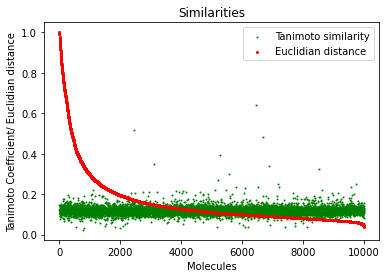

In [13]:
data_smiles['Tanimoto_Similarity'] = tan_sim
data_smiles['Euclidian_distance'] = euc_list

data_smiles.to_csv('./latent_space/shaakabraah/data_smiles_with_tanimoto_and_euclidian.txt')


data_smiles= data_smiles.sort_values(by =  'Tanimoto_Similarity', ascending = False)
data_smiles_copy = data_smiles
data_smiles_copy = data_smiles_copy.sort_values(by = 'Euclidian_distance', ascending = False)
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(np.arange(0,len(data_smiles)), data_smiles_copy['Tanimoto_Similarity'], s = 1, label = 'Tanimoto similarity', c= 'green')
plt.scatter(np.arange(0,len(data_smiles)),data_smiles_copy['Euclidian_distance'], s = 4, label = 'Euclidian distance', c  = 'red')
plt.title('Similarities')
plt.ylabel('Tanimoto Coefficient/ Euclidian distance')
plt.xlabel('Molecules')
plt.legend()